In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import os

Below is the smoothed/seasonally adjusted SFR, condo/coop time series of all homes, found here: 

https://www.zillow.com/research/data/

In [2]:
zillow = pd.read_csv("Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")

In [3]:
#Ok, some of the zip codes are wrong - for example, Boston Zip codes are missing the first unit,
#since they start with "0". So let's fix this, by adding a "0" to the start of every zip code
#that is only length 4

zip_list = list(zillow['RegionName'])

new_zips = []
for i in zip_list:
    if len(str(i))==4:
        zip_val = '0'+str(i)
        new_zips.append(zip_val)
    else:
        new_zips.append(str(i))

zillow['ZipCode']=new_zips

In [4]:
zillow_cols = list(zillow.columns)
date_cols = zillow_cols[9:-1]

In [5]:
def plot_zip(zip):
    zip_df = zillow[zillow['ZipCode']==zip]
    price_array = zip_df[date_cols].iloc[0]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(date_cols,price_array)
    ax.set_ylabel('Median Home Price')
    ax.set_xlabel('Date')
    ax.set_title('Price Appreciation in Zipcode '+ str(zip))
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 18th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::18]))
    for label in temp:
        label.set_visible(False)
    
    plt.show()
    

In [6]:
def plot_zips(zips,title='Price Appreciation Across Multiple Zipcodes'):
    
    price_arrays = []
    for zipcode in zips:
        zip_df = zillow[zillow['ZipCode']==zipcode]
        price_array = zip_df[date_cols].iloc[0]
        price_arrays.append(price_array)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for i in range(len(zips)):
        ax.plot(date_cols,price_arrays[i],label=str(zips[i]))
        
    ax.set_ylabel('Median Home Price')
    ax.set_xlabel('Date')
    #ax.set_title('Price Appreciation in Zipcode '+ str(zip))
    ax.set_title(title)
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 24th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::24]))
    for label in temp:
        label.set_visible(False)
    
    ax.legend()
    plt.show()

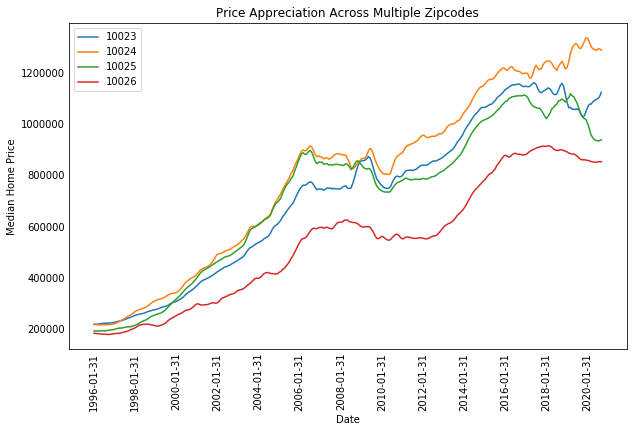

In [7]:
plot_zips(['10023','10024','10025','10026'])

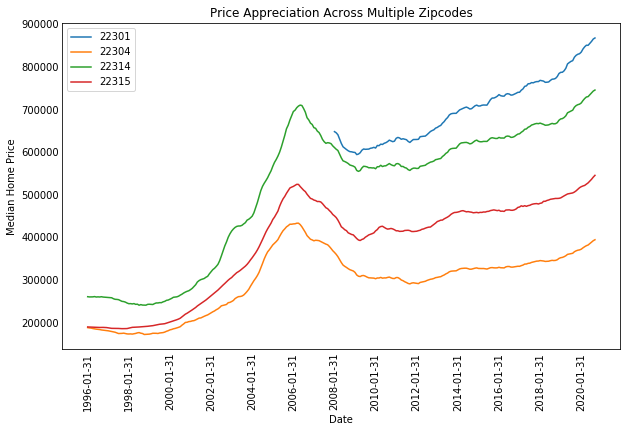

In [8]:
plot_zips(['22301','22304','22314','22315'])

Ok! Great. Now let's write a function to calculate the appreciation from an arbitrary date in the past up to now. 

In [9]:
def calc_apprec(zipcode,year):
    year_col = str(year)+'-01-31'
    
    zip_df = zillow[zillow['ZipCode']==zipcode]
    past_price = float(zip_df[year_col])
    
    current_price = float(zip_df['2020-09-30'])
    
    appreciation = (current_price - past_price)/past_price
    
    return appreciation
    

In [10]:
def city_apprecs(city,state,year):
    city_df = zillow[zillow['City']==city]
    city_df = city_df[city_df['State']==state]
    
    city_zips = list(city_df['ZipCode'])
    
    apprecs = []
    for zipcode in city_zips:
        apprecs.append(calc_apprec(zipcode,year))
    
    apprec_df = pd.DataFrame(list(zip(city_zips,apprecs)),columns=['Zipcode','Appreciation'])
    apprec_df = apprec_df.sort_values(by='Appreciation',ascending=False)
    apprec_df = apprec_df.reset_index()
    apprec_df = apprec_df.drop(['index'], axis=1)
    
    return apprec_df

In [11]:
def plot_city_apprecs(city,state,year):
    apprec_df = city_apprecs(city,state,year)

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax = sns.barplot(apprec_df["Zipcode"], apprec_df['Appreciation'],order=apprec_df.sort_values("Appreciation",ascending=False).Zipcode,palette = "GnBu_d")
    ax.set_ylabel('Appreciation')
    ax.set_xlabel('Zipcode')
    ax.set_title('Appreciation across Zipcodes in '+ str(city) +'\n'+str(year)+'-present')
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    plt.show()


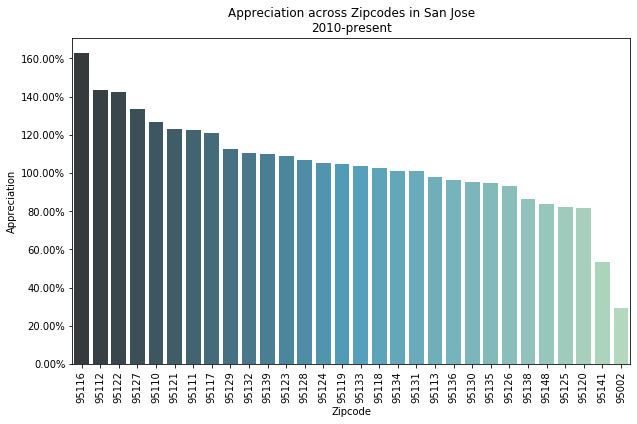

In [12]:
plot_city_apprecs("San Jose","CA",2010)

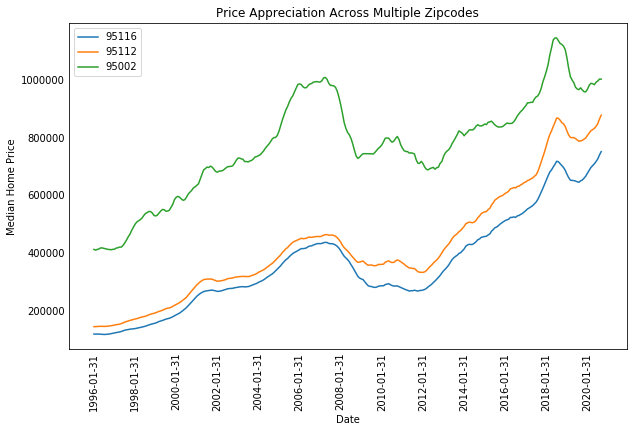

In [13]:
plot_zips(['95116','95112','95002'])

NOTE: It would be very easy to make some attractive maps on the basis of the above. Could probably even do this in Python. 

Now let's read in the demographic data by zipcode from Social Exporer.

All the below from here: https://www.socialexplorer.com/explore-tables

In [14]:
#This is the data itself
acs_df = pd.read_csv('ACS_social_explorer.csv')

#And this is the dictionary of variable codes and what they stand for, which I have edited
acs_vars = pd.read_csv('acs_2018_data_dictionary_PYTHON.csv')

#Turn this into a dictionary
acs_vars_dict = dict(zip(acs_vars['ACSVariable'],acs_vars['New Name']))

In [15]:
#Let's clean up the column names a bit
acs_columns = list(acs_df.columns)
acs_new_cols = []
for i in acs_columns:
    acs_new_cols.append(i.replace('SE_',''))

#Let's rename the columns
acs_df.columns = acs_new_cols

In [16]:
#Let's add some meaningful new columns
acs_df['White_portion'] = acs_df['B04001_003']/acs_df['B04001_001']
acs_df['Black_portion'] = acs_df['B04001_004']/acs_df['B04001_001']
acs_df['Hispanic_portion'] = acs_df['B04001_010']/acs_df['B04001_001']
acs_df['Asian_portion'] = acs_df['B04001_006']/acs_df['B04001_001']
acs_df['Unemployed_portion'] = acs_df['A17005_003']/acs_df['A17005_001']


In [17]:
impt_cols = [
    'Geo_NAME', #Zip Code
    'A00001_001', #Population
    'A00002_002', #Density
    'A14006_001', #Median household income
    'White_portion',
    'Black_portion',
    'Hispanic_portion',
    'Asian_portion',
    'Unemployed_portion']

acs_df = acs_df[impt_cols]

In [18]:
acs_df = acs_df.rename(columns={'Geo_NAME':'ZipCode','A00001_001': 'Pop_2018','A00002_002':'Pop_density','A14006_001':'Med_income'})


In [19]:
zip_codes = list(acs_df['ZipCode'])

new_zips = []
for i in zip_codes:
    new_zips.append(i[-5:])

acs_df['ZipCode'] = new_zips

Ok, so now let's merge this ACS dataframe with our Zillow dataframe, on the common column "ZipCode". Note that the Zillow df is a bit smaller (~30,000 vs 33,000) but that's ok, I think.

In [20]:
master_df = pd.merge(zillow,acs_df,on='ZipCode')

Note: You'll have to weight everything by population in each zipcode. Start doing this below.

In [21]:
#Lets just get the 50 largest metro areas
metros = list(master_df['Metro'].value_counts().index)[0:50]

In [22]:
def plot_metros(metros,title='Price Appreciation Across Multiple Metro Areas, 1996-2020'):
    
    metro_dfs = []
    price_arrays = []
    for metro in metros:
        metro_df = master_df[master_df['Metro']==metro]
        #price_array = np.mean(metro_df[date_cols]) 
        #price_arrays.append(price_array)
        
        #The below is the roundabout way for calculating the weighted average (by Zipcode population)
        price_array_list = []
        
        for i in date_cols:
            mean_df = metro_df[['RegionName',i,'Pop_2018']]
            mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
            price_array = mean_df[i]
            weight_array = mean_df['Pop_2018']
            
            weight_avg_price = np.average(price_array,weights=weight_array)
            price_array_list.append(weight_avg_price)
        
        price_arrays.append(price_array_list)
    
    #The below also calculates the weighted average for national average
    national_avg = []
        
    for i in date_cols:
        mean_df = master_df[['RegionName',i,'Pop_2018']]
        mean_df = master_df.dropna(subset=[i,'Pop_2018'])
            
        price_array = mean_df[i]
        weight_array = mean_df['Pop_2018']
            
        weight_avg_price = np.average(price_array,weights=weight_array)
        national_avg.append(weight_avg_price)    
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for i in range(len(metros)):
        ax.plot(date_cols,price_arrays[i],label=str(metros[i]))
        
    ax.plot(date_cols,national_avg,label='National Average',linewidth=2,color='k')
    ax.set_ylabel('Median Home Price')
    ax.set_xlabel('Date')
    ax.set_title(title)
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 24th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::24]))
    for label in temp:
        label.set_visible(False)
    
    ax.legend()
    plt.show()

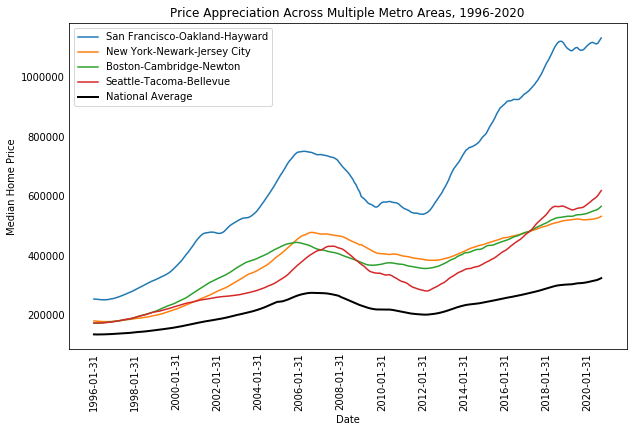

In [23]:
#plot_metros([metros[0],'San Francisco-Oakland-Hayward','Seattle-Tacoma-Bellevue','Denver-Aurora-Lakewood'])
#plot_metros(['San Francisco-Oakland-Hayward',metros[0],'Seattle-Tacoma-Bellevue','Pittsburgh'])
plot_metros(['San Francisco-Oakland-Hayward',metros[0],'Boston-Cambridge-Newton','Seattle-Tacoma-Bellevue'])



(Note that the above approach, weighting  by zipcode population, is very time consuming/computationally intensive, and doesn't yield particularly different results than just the normal approach.)

Interesting. Percentage-wise, San Francisco's price appreciation hasn't been remarkable, but in absolute terms it's been very significant and dwarfs that of other regions. 

Cool! It worked. Now let's add a column for a 2015-2020 appreciation percentage for each zipcode.

In [24]:
def col_apprec(df,year):
    year_col = str(year)+'-01-31'

    past_price = df[year_col]
    current_price = df['2020-09-30']
    
    appreciation = (current_price - past_price)/past_price
    
    col_title = str(year)+'-2020 apprec.'
    df[col_title] = appreciation
    
    return df

In [25]:
master_df = col_apprec(master_df,2015)
reg_df = master_df.dropna(subset=['Pop_density', '2015-2020 apprec.'])
reg_df = reg_df[reg_df['Pop_density']>0] #For the heck of it, let's just get zipcodes where there is some pre-existing population

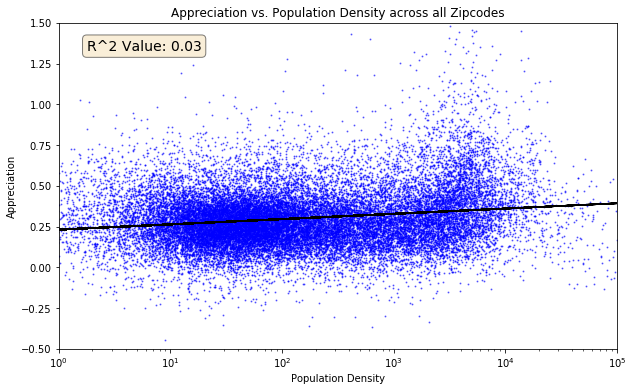

In [26]:
#Let's compute the regression line for this one variable
x = reg_df['Pop_density']
y = reg_df['2015-2020 apprec.']
slope, intercept, r_value, p_value, std_err = linregress(np.log(x), y)  

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(master_df['Pop_density'],master_df['2015-2020 apprec.'],s=1,alpha=0.5,color='b')
ax.set_ylabel('Appreciation')
ax.set_xlabel('Population Density')
ax.set_title('Appreciation vs. Population Density across all Zipcodes')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)

#And then let's add the regression line to the plot
ax.plot(x,slope*np.log(x)+intercept,c= "k")
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax.set_xlim([1,100000])
ax.set_ylim([-0.5,1.5])
ax.set_xscale('log')

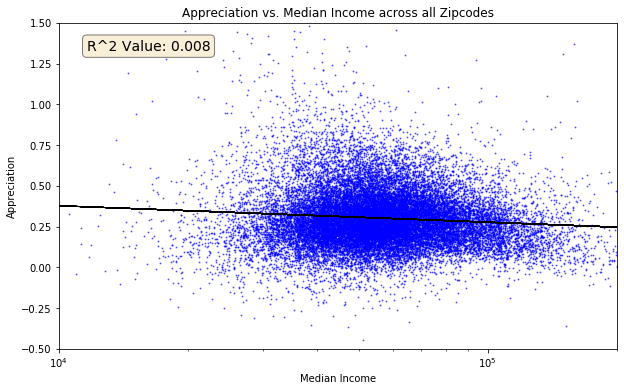

In [27]:
#Let's compute the regression line for this one variable
reg_df = master_df.dropna(subset=['Med_income', '2015-2020 apprec.'])
reg_df = reg_df[reg_df['Med_income']>0] #For the heck of it, let's just get zipcodes where there is some pre-existing population

x = reg_df['Med_income']
y = reg_df['2015-2020 apprec.']
slope, intercept, r_value, p_value, std_err = linregress(np.log(x), y)  

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(master_df['Med_income'],master_df['2015-2020 apprec.'],s=1,alpha=0.5,color='b')
ax.set_ylabel('Appreciation')
ax.set_xlabel('Median Income')
ax.set_title('Appreciation vs. Median Income across all Zipcodes')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)

#And then let's add the regression line to the plot
ax.plot(x,slope*np.log(x)+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlim([10000,200000])
ax.set_ylim([-0.5,1.5])
ax.set_xscale('log')

(-0.5, 1.5)

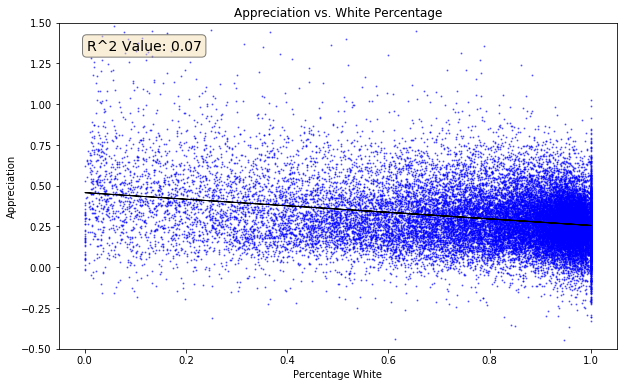

In [28]:
#Let's compute the regression line for this one variable
reg_df = master_df.dropna(subset=['White_portion', '2015-2020 apprec.'])
reg_df = reg_df[reg_df['White_portion']>0] #For the heck of it, let's just get zipcodes where there is some pre-existing population

x = reg_df['White_portion']
y = reg_df['2015-2020 apprec.']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(master_df['White_portion'],master_df['2015-2020 apprec.'],s=1,alpha=0.5,color='b')
ax.set_ylabel('Appreciation')
ax.set_xlabel('Percentage White')
ax.set_title('Appreciation vs. White Percentage')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)

#And then let's add the regression line to the plot
ax.plot(x,slope*x+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.set_xlim([10000,500000])
ax.set_ylim([-0.5,1.5])
#ax.set_xscale('log')

As we can see, none of these are particularly revealing. What happens when we start looking at individual metropolitan areas?

In [29]:
#Let's just get the list of 50 largest metros (by number of zipcodes - so not exactly exact)
metros = zillow['Metro'].value_counts()[0:30].index

In [30]:
metro_apprecs = []
for metro in metros:
    metro_df = master_df[master_df['Metro']==metro]
    metro_apprec = np.mean(metro_df['2015-2020 apprec.'])
    metro_apprecs.append(metro_apprec)
    
metro_apprecs_df = pd.DataFrame(list(zip(metros,metro_apprecs)),columns=['Metro','Appreciation'])
metro_apprecs_df = metro_apprecs_df.sort_values(by='Appreciation',ascending=False)


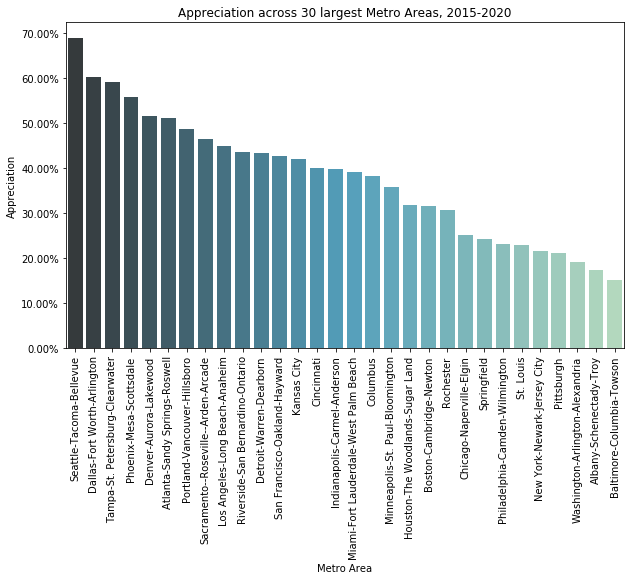

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(metro_apprecs_df["Metro"], metro_apprecs_df['Appreciation'],order=metro_apprecs_df.sort_values("Appreciation",ascending=False).Metro,palette = "GnBu_d")
ax.set_ylabel('Appreciation')
ax.set_xlabel('Metro Area')
ax.set_title('Appreciation across 30 largest Metro Areas, 2015-2020')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.show()

Note: I would imagine population growth is a big predictor of price appreciation.

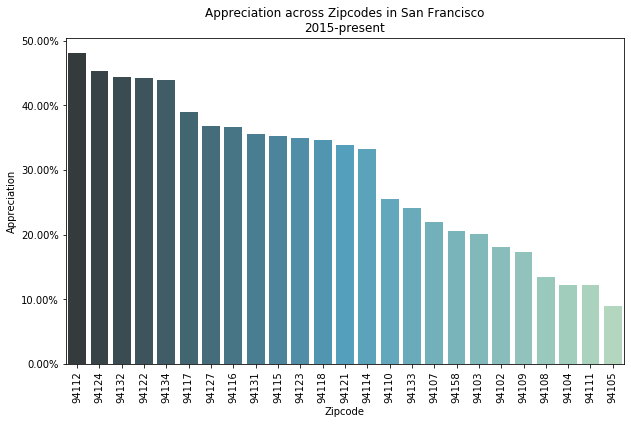

In [32]:
plot_city_apprecs("San Francisco","CA",2015)

Note: the above bar plots may be better replaced by violin/boxplots. 

Note: It would be cool to make that kind of price appreciation plot to compare metro areas, rather than just comparing zipcodes within metro areas.

Ok, so it would be nice to see how population growth relates to price appreciation. So let's read in population data by zipcode from the 2013 ACS.

In [33]:
#This is the data itself
acs_2013 = pd.read_csv('acs_2013.csv')

In [34]:
#Let's clean up the column names a bit
acs_2013_cols = list(acs_2013.columns)
acs_new_cols = []
for i in acs_2013_cols:
    acs_new_cols.append(i.replace('SE_',''))

#Let's rename the columns
acs_2013.columns = acs_new_cols

In [35]:
impt_cols = [
    'Geo_NAME', #Zip Code
    'A00001_001'] #Population

acs_2013 = acs_2013[impt_cols]

In [36]:
acs_2013 = acs_2013.rename(columns={'Geo_NAME':'ZipCode','A00001_001': 'Pop_2013'})


In [37]:
zip_codes = list(acs_2013['ZipCode'])

new_zips = []
for i in zip_codes:
    new_zips.append(i[0:5])

acs_2013['ZipCode'] = new_zips

In [38]:
#Let's merge this 2013 data with the 2018 data and then add a column representing population increase
master_df = pd.merge(master_df,acs_2013,on='ZipCode')
master_df['Pop Increase 2013-2018'] = (master_df['Pop_2018']-master_df['Pop_2013'])/master_df['Pop_2013']


(-0.5, 1.5)

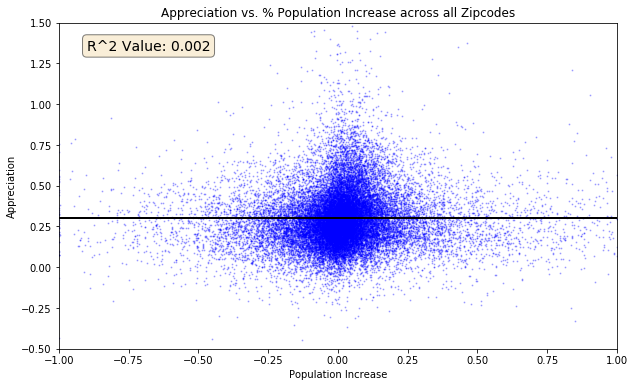

In [39]:
#Let's compute the regression line for this one variable
reg_df = master_df.dropna(subset=['Pop Increase 2013-2018', '2015-2020 apprec.'])
reg_df = reg_df[reg_df['Pop Increase 2013-2018']<np.inf] #For the heck of it, let's just get zipcodes where there is some pre-existing population

x = reg_df['Pop Increase 2013-2018']
y = reg_df['2015-2020 apprec.']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  

#Now let's visualize this
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(master_df['Pop Increase 2013-2018'],master_df['2015-2020 apprec.'],s=1,alpha=0.25,color='b')
ax.set_ylabel('Appreciation')
ax.set_xlabel('Population Increase')
ax.set_title('Appreciation vs. % Population Increase across all Zipcodes')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)

#And then let's add the regression line to the plot
ax.plot(x,slope*x+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax.set_xlim([-1,1.0])
ax.set_ylim([-0.5,1.5])
#ax.set_xscale('log')

No obvious relationship here, but perhaps the trends will be more evident if we look within individual metropolitan areas.

(-0.25, 1.5)

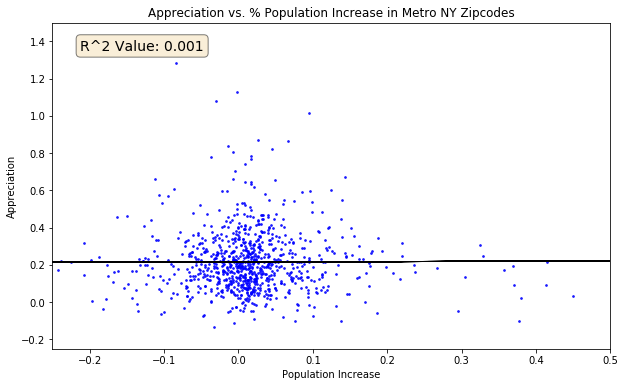

In [40]:
nyc_df = master_df[master_df['Metro']=='New York-Newark-Jersey City']

#Let's compute the regression line for this one variable
reg_df = nyc_df.dropna(subset=['Pop Increase 2013-2018', '2015-2020 apprec.'])
reg_df = reg_df[reg_df['Pop Increase 2013-2018']<np.inf] #For the heck of it, let's just get zipcodes where there is some pre-existing population

x = reg_df['Pop Increase 2013-2018']
y = reg_df['2015-2020 apprec.']
slope, intercept, r_value, p_value, std_err = linregress(x, y)  


#Now let's visualize this
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(nyc_df['Pop Increase 2013-2018'],nyc_df['2015-2020 apprec.'],s=3,alpha=0.8,color='b')
ax.set_ylabel('Appreciation')
ax.set_xlabel('Population Increase')
ax.set_title('Appreciation vs. % Population Increase in Metro NY Zipcodes')
ax.ticklabel_format(style='plain', axis='y',useOffset=False)

#And then let's add the regression line to the plot
ax.plot(x,slope*x+intercept,c= "k",linewidth=1)
disp_r_value = round(r_value**2,3)
display_text = "R^2 Value: "+ str(disp_r_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax.set_xlim([-0.25,0.5])
ax.set_ylim([-0.25,1.5])
#ax.set_xscale('log')

No relationship whatsoever! This is in fact pretty surprising.

Some things to do next: 

Write code to visualize the top n most populous zipcodes in a given metro area/city. 

Plot the regression line and R^2 value on the scatter plots above. 

Maybe do some more serious regression analysis: how much do population increase, median income, and population density together explain price appreciation? And perhaps you could build a hierarchical model: with each metro area/city as a categorical variable/category?

Plot price appreciation trajectory by density category, by median income, etc. within each metro area.

### By category within metro area

In [41]:
nyc_df = master_df[master_df['Metro']=='New York-Newark-Jersey City']

zip_pops = nyc_df.groupby('ZipCode', as_index=False)['Pop_2018'].mean()
zip_pops = zip_pops.sort_values(by="Pop_2018",ascending=False)
top_zips = list(zip_pops.head(5)['ZipCode'])

Ok, so first, let's write a function to plot the appreciation trajectory of the top n most populous zipcodes in a given metro area.

In [42]:
def plot_metro_zips(metro,num_zips):
    
    metro_df = master_df[master_df['Metro']==metro]
    
    #Get the top zipcodes by 2018 population
    zip_pops = metro_df.groupby('ZipCode', as_index=False)['Pop_2018'].mean()
    zip_pops = zip_pops.sort_values(by="Pop_2018",ascending=False)
    top_zips = list(zip_pops.head(num_zips)['ZipCode'])
    
    price_arrays = []
    for zipcode in top_zips:
        zip_df = metro_df[metro_df['ZipCode']==zipcode]
        price_array = zip_df[date_cols].iloc[0]
        price_arrays.append(price_array)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for i in range(len(top_zips)):
        ax.plot(date_cols,price_arrays[i],label=str(top_zips[i]))
    
    metrowide_avg = np.mean(metro_df[date_cols])
    ax.plot(date_cols,metrowide_avg,label='Metro-wide Average',linewidth=2,color='k')
        
    ax.set_ylabel('Median Home Price')
    ax.set_xlabel('Date')
    ax.set_title('Price Appreciation in the '+ str(num_zips) + ' most populous Zipcodes in '+ str(metro))
    #ax.set_title(title)
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
    ax.grid(False) ####
    
    #Only show every 24th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::24]))
    for label in temp:
        label.set_visible(False)
    
    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
 
    ax.legend()
    plt.show()

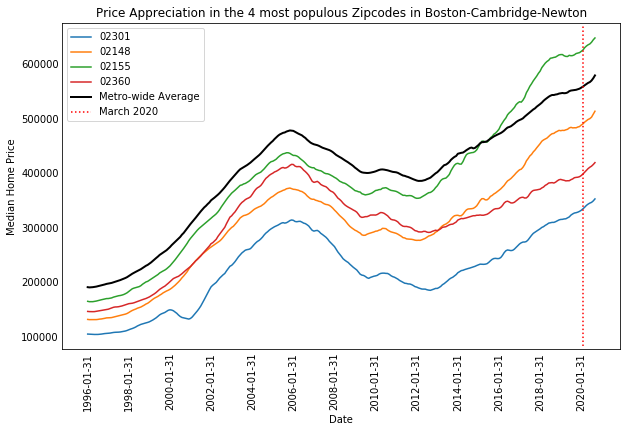

In [43]:
#plot_metro_zips('Chicago-Naperville-Elgin',4)
plot_metro_zips(metros[6],4)

Note that the most populous zipcodes in a given area tend to have below-average prices (and what would appear to be below-average price appreciation) than the metro area as a whole. 

Now let's try to visualize the price appreciation trajectory for different income/demographic categories within a given metro area. 

In [44]:
def plot_category_trend(metro,category,num_bins,cat_title,legend_title=None):
    
    metro_df = master_df[master_df['Metro']==metro]
    metro_df = metro_df.replace([np.inf, -np.inf], np.nan)
    metro_df = metro_df.dropna(subset=[category])
    metro_df['Bins'] = pd.qcut(metro_df[category], q=num_bins)
    
    cat_labels = []
    origs = []
    
    cats = list(set(metro_df['Bins']))
    cats.sort()
    
    for i in range(len(cats)): 
        a = cats[i]
        #cat_labels.append(str(i+1)+': '+str([int(round(a.left,-2)),int(round(a.right,-2))]))
        cat_labels.append(str(i+1)+': '+str(int(round(a.left,-2)))+' - '+str(int(round(a.right,-2))))
        origs.append(a)
    
    #Relabeling the categories
    label_dict = dict(zip(origs,cat_labels))
    new_labels = []
    for i in list(metro_df['Bins']):
        new_labels.append(str(label_dict[i]))

    metro_df['Bins'] = new_labels
    
    #Getting the price array for each category
    price_arrays = []
    for label in cat_labels:
        cat_df = metro_df[metro_df['Bins']==label]
    
        #The below is the roundabout way for calculating the weighted average (by Zipcode population)
        price_array_list = []
        
        for i in date_cols:
            mean_df = cat_df[['RegionName',i,'Pop_2018']]
            mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
            price_array = mean_df[i]
            weight_array = mean_df['Pop_2018']
            
            weight_avg_price = np.average(price_array,weights=weight_array)
            price_array_list.append(weight_avg_price)
        
        price_arrays.append(price_array_list)
    
    #And for the metro-area as a whole
    #metrowide_avg = np.mean(metro_df[date_cols])
    
    
    #The below also calculates the weighted average for the metro-area as a whole
    metrowide_avg = []
        
    for i in date_cols:
        mean_df = metro_df[['RegionName',i,'Pop_2018']]
        mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
        price_array = mean_df[i]
        weight_array = mean_df['Pop_2018']
            
        weight_avg_price = np.average(price_array,weights=weight_array)
        metrowide_avg.append(weight_avg_price)  
    
    #Now plot the above
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for i in range(len(cat_labels)):
        ax.plot(date_cols,price_arrays[i],label=str(cat_labels[i]))
    ax.plot(date_cols,metrowide_avg,label='Metro-wide Average',linewidth=2,color='k') 
    ax.set_ylabel('Median Home Price')
    ax.set_xlabel('Date')
    ax.set_title('Home sale price across '+ cat_title + ' categories in '+ str(metro))
    
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
    ax.grid(False)
    
    #Only show every 24th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::24]))
    for label in temp:
        label.set_visible(False)
    
    #Ok, now let's try to re-order the handles and labels according to their order on the plot
    #handles,labels = ax.get_legend_handles_labels()
    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
 
    ax.legend(title=legend_title)
    
    plt.show()



Note: Sooner or later you should fix the order of the labels, so that they are in order largest-smallest.

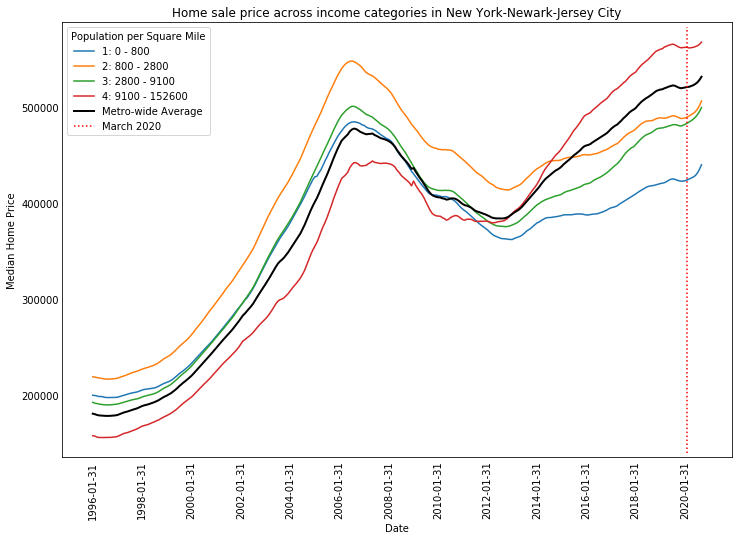

In [45]:
plot_category_trend(metros[0],'Pop_density',4,'income',legend_title='Population per Square Mile')

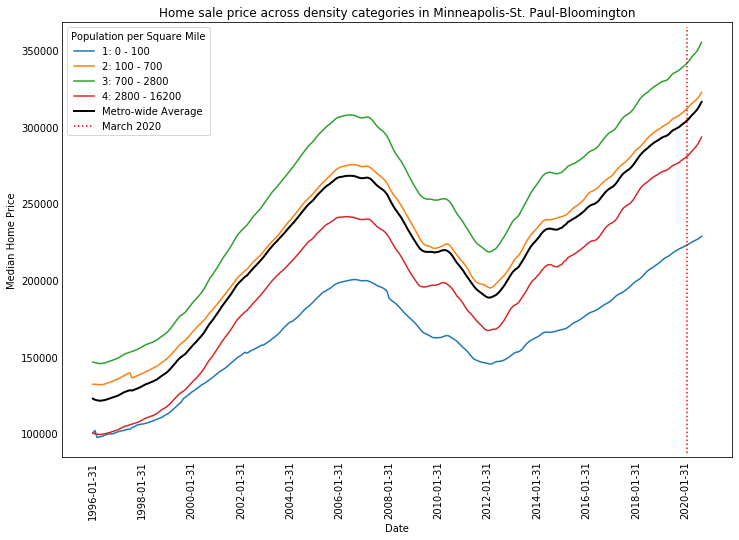

In [46]:
plot_category_trend(metros[9],'Pop_density',4,'density',legend_title='Population per Square Mile')

Ok, next step: let's see how year-over-year appreciation has changed over time for these different categories. 

In [47]:
def calc_appreciation_trend(price_array):
    apprec_array = []
    #Note: this has to be plus/minus twelve because the data is monthly
    for i in range(len(price_array)-12):
        current_val = price_array[i+12]
        prev_val = price_array[i]
        
        yoy_apprec = (current_val - prev_val)/prev_val
        apprec_array.append(yoy_apprec)
    
    return apprec_array

In [48]:
import matplotlib as mpl

Ok, it's best if we break the formula to plot the appreciation trend into several smaller, discrete formulas - without that, it's a massive, unreadable thing. 

So let's first write a formula to get just the relevant date columns (the appreciation graphs are more readable for a narrower subset of months). 

In [49]:
def get_date_cols(df,start_year,start_month):   
    
    master_cols = list(df.columns)
    
    start_year_adjusted = str(int(start_year) - 1)
    
    start_col = str(start_year_adjusted) +'-'+ str(start_month)
    match_list = [start_col in i for i in master_cols]
    start_date_index = next((i for i, j in enumerate(match_list) if j), None) #Complicated, I know - but this gets the index of hte matching date column

    end_year = '2020'
    end_month = '09'

    end_col = str(end_year) +'-'+ str(end_month)
    match_list = [end_col in i for i in master_cols]
    end_date_index = next((i for i, j in enumerate(match_list) if j), None) #Complicated, I know - but this gets the index of hte matching date column

    master_cols = list(df.columns)
    date_cols = master_cols[start_date_index:end_date_index]
    
    return date_cols

In [50]:
def get_category_bins(df,category,num_bins,decs=-2):
    
    bins = pd.qcut(df[category], q=num_bins)
    
    cat_labels = []
    origs = []
    
    cats = list(set(bins))
    cats = [x for x in cats if str(x) != 'nan']
    cats.sort()
    
    for i in range(len(cats)): 
        a = cats[i]
        cat_labels.append(str(i+1)+': '+str(float(round(a.left,decs)))+' - '+str(float(round(a.right,decs))))
        origs.append(a)
    
    #Relabeling the categories
    label_dict = dict(zip(origs,cat_labels))
    new_labels = []
    for i in list(bins):
        new_labels.append(str(label_dict[i]))

    return new_labels,cat_labels

In [51]:
#Now let's write a formula to calculate the average for a range of date columns in a df weighted by zipcode population
def calc_weighted_avg(df,date_cols):
    
    #The below is the roundabout way for calculating the weighted average (by Zipcode population)
    price_array_list = []
        
    for i in date_cols:
        mean_df = df[['RegionName',i,'Pop_2018']]
        mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
        price_array = mean_df[i]
        weight_array = mean_df['Pop_2018']
            
        weight_avg_price = np.average(price_array,weights=weight_array)
        price_array_list.append(weight_avg_price)
        
    return price_array_list
    

In [52]:
def plot_appreciation_trend(df,metro,category,num_bins,cat_title,start_year,start_month,legend_title=None):
    
    #get the relevant date columns
    date_cols = get_date_cols(df,start_year,start_month)
    
    metro_df = df[df['Metro']==metro]
    metro_df = metro_df.replace([np.inf, -np.inf], np.nan)
    metro_df = metro_df.dropna(subset=[category])
    
    #Create a new column with appropriately-labeled categories
    new_labels,cat_labels = get_category_bins(metro_df,category,num_bins)
    metro_df['Bins'] = new_labels
    
    #Now get the price array for each category
    price_arrays = []
    for label in cat_labels:
        cat_df = metro_df[metro_df['Bins']==label]
    
        #Let's calculate the weighted average across the date columns for every bin
        price_array_list = calc_weighted_avg(cat_df,date_cols)
        price_arrays.append(price_array_list)
        
    #The below also calculates the weighted average for the metro-area as a whole
    metrowide_avg = calc_weighted_avg(metro_df,date_cols)
    
    #And now let's calculate the year_over_year appreciation for the metro-wide price array
    metrowide_apprec = calc_appreciation_trend(metrowide_avg)
    
    #...and then for every individual category price array
    apprec_arrays = []
    
    for i in price_arrays:
        apprec_array = calc_appreciation_trend(i)
        apprec_arrays.append(apprec_array)
    
    #Now plot the above
    mpl.style.use('ggplot') ###I like the ggplot style but we don't have to use this necessarily
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for i in range(len(cat_labels)):
        ax.plot(date_cols[12:],apprec_arrays[i],label=str(cat_labels[i])) #Same: this has to be plus 12
    ax.plot(date_cols[12:],metrowide_apprec,label='Metro-wide Appreciation',linewidth=2,color='k') 
    ax.set_ylabel('Year-over-year appreciation')
    ax.set_xlabel('Date')
    ax.set_title('Year-over-year price Appreciation across different '+ cat_title + ' categories \n in '+ str(metro) + ', ' + str(start_year) + '-2020')
    
    #Hide the gridlines
    ax.grid(False)
    
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 12th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::12]))
    for label in temp:
        label.set_visible(False)
    
    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
    
    ax.legend(title=legend_title)
    
    plt.show()



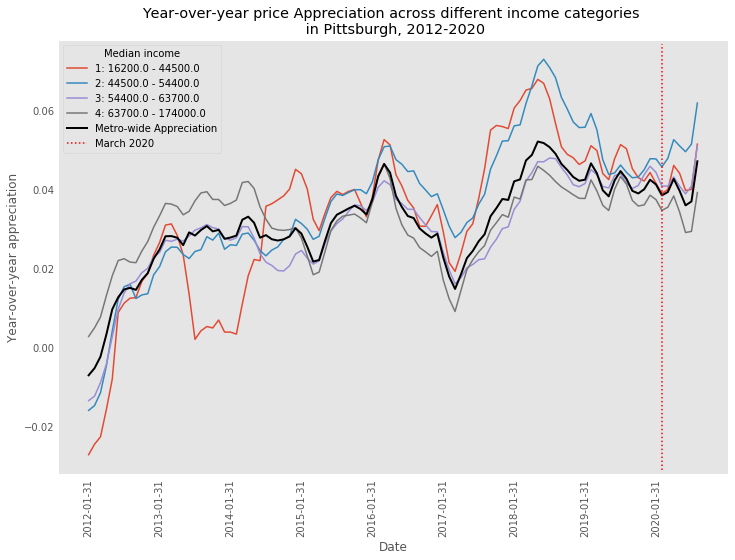

In [53]:
plot_appreciation_trend(master_df,metros[4],'Med_income',4,'income','2012','01',legend_title='Median income')


Note that this is very hard to read. Maybe if we look at a smaller subset of years/dates.

In [54]:
#Let's subset some interesting metro areas
metro_set = ['New York-Newark-Jersey City','Los Angeles-Long Beach-Anaheim','Washington-Arlington-Alexandria',
             'Boston-Cambridge-Newton','Houston-The Woodlands-Sugar Land','San Francisco-Oakland-Hayward']



Ok, let's write a script to put all of these plots together on a single block.

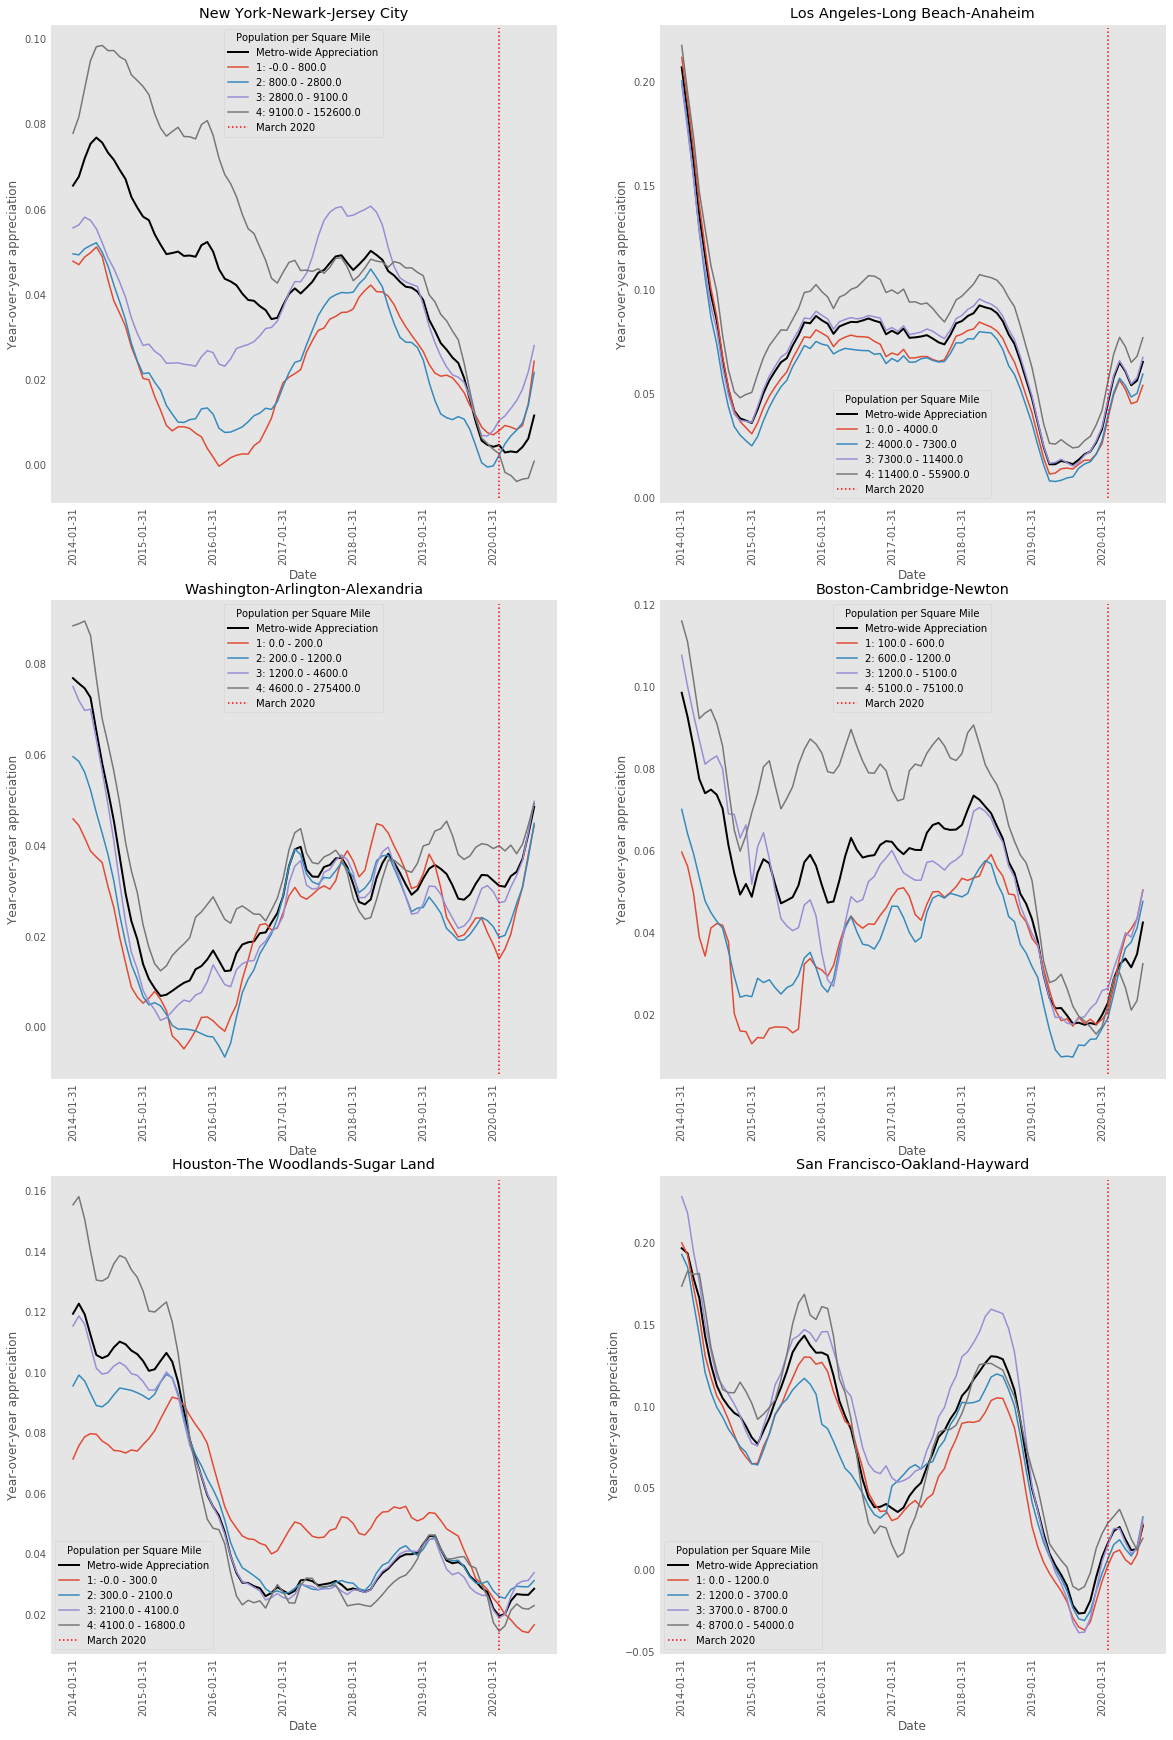

In [55]:
#Plot grid
mpl.style.use('ggplot')

category = "Pop_density"
num_bins = 4
cat_title = "density"
start_year = "2014"
start_month = "01"
legend_title = "Population per Square Mile"

fig,ax = plt.subplots(3,2,figsize=(20,30))

for i in range(3):
    for j in range(2):
        order = i*2 + j
        metro = metro_set[order]

        metro_df = master_df[master_df['Metro']==metro]
        metro_df = metro_df.replace([np.inf, -np.inf], np.nan)
        metro_df = metro_df.dropna(subset=[category])
        
        #get the relevant date columns
        date_cols = get_date_cols(metro_df,start_year,start_month)

        #Create a new column with appropriately-labeled categories
        new_labels,cat_labels = get_category_bins(metro_df,category,num_bins)
        metro_df['Bins'] = new_labels

        #Now get the price array for each category
        price_arrays = []
        for label in cat_labels:
            cat_df = metro_df[metro_df['Bins']==label]

            #Let's calculate the weighted average across the date columns for every bin
            price_array_list = calc_weighted_avg(cat_df,date_cols)
            price_arrays.append(price_array_list)

        #The below also calculates the weighted average for the metro-area as a whole
        metrowide_avg = calc_weighted_avg(metro_df,date_cols)

        #And now let's calculate the year_over_year appreciation for the metro-wide price array
        metrowide_apprec = calc_appreciation_trend(metrowide_avg)

        #...and then for every individual category price array
        apprec_arrays = []

        for k in price_arrays:
            apprec_array = calc_appreciation_trend(k)
            apprec_arrays.append(apprec_array)
        
        #And now let's set up the plot!
        ax[i,j].plot(date_cols[12:],metrowide_apprec,label='Metro-wide Appreciation',linewidth=2,color='k')
        for m in range(len(cat_labels)):
            ax[i,j].plot(date_cols[12:],apprec_arrays[m],label=str(cat_labels[m]))        
        ax[i,j].set_ylabel('Year-over-year appreciation')
        ax[i,j].set_xlabel('Date')
        ax[i,j].set_title(str(metro))

        #Hide the gridlines
        ax[i,j].grid(False)

        ax[i,j].ticklabel_format(style='plain', axis='y',useOffset=False)
        for tick in ax[i,j].get_xticklabels():
            tick.set_rotation(90)

        ax[i,j].tick_params(axis ='both', which ='both', length = 0)

        #Only show every 12th label
        temp = ax[i,j].xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::12]))
        for label in temp:
            label.set_visible(False)
            
        ax[i,j].axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
 

        ax[i,j].legend(title=legend_title)

#plt.tight_layout()
#plt.subplots_adjust(top=1.5)
#fig.suptitle('Year-over-year price appreciation across '+ cat_title + ' categories in different metropolitan areas, ' + str(start_year) + '-2020')
plt.show()

Ok, now let's visualize the appreciation trend for categories nationwide. We can do this just by tweaking our "plot category trend" function. 

Note to self: fix the below with the new formulas you've created to make it less cluttered.

In [56]:
def plot_appreciation_trend_national(category,num_bins,cat_title,start_year,start_month,legend_title=None):
    
    #OK, best to be able to set the beginning date because these plots are pretty hard to read
    master_cols = list(master_df.columns)
    
    start_year_adjusted = str(int(start_year) - 1)
    
    start_col = str(start_year_adjusted) +'-'+ str(start_month)
    match_list = [start_col in i for i in master_cols]
    start_date_index = next((i for i, j in enumerate(match_list) if j), None) #Complicated, I know - but this gets the index of hte matching date column

    end_year = '2020'
    end_month = '09'

    end_col = str(end_year) +'-'+ str(end_month)
    match_list = [end_col in i for i in master_cols]
    end_date_index = next((i for i, j in enumerate(match_list) if j), None) #Complicated, I know - but this gets the index of hte matching date column

    master_cols = list(master_df.columns)
    date_cols = master_cols[start_date_index:end_date_index]
    ###############
    
    #metro_df = master_df[master_df['Metro']==metro]
    new_master_df = master_df.replace([np.inf, -np.inf], np.nan)
    #Let's also get rid of zipcodes with 0 population density, since this doesn't make sense
    new_master_df = new_master_df[new_master_df['Pop_density']>1]
    ###
    new_master_df = new_master_df.dropna(subset=[category])
    new_master_df['Bins'] = pd.qcut(new_master_df[category], q=num_bins)
    
    cat_labels = []
    origs = []
    
    cats = list(set(new_master_df['Bins']))
    cats.sort()
    
    for i in range(len(cats)): 
        a = cats[i]
        cat_labels.append(str(i+1)+': '+str(int(round(a.left,2)))+' - '+str(int(round(a.right,2))))
        origs.append(a)
    
    #Relabeling the categories
    label_dict = dict(zip(origs,cat_labels))
    new_labels = []
    for i in list(new_master_df['Bins']):
        new_labels.append(str(label_dict[i]))

    new_master_df['Bins'] = new_labels
    
    #Getting the price array for each category
    price_arrays = []
    for label in cat_labels:
        cat_df = new_master_df[new_master_df['Bins']==label]
    
        #The below is the roundabout way for calculating the weighted average (by Zipcode population)
        price_array_list = []
        
        for i in date_cols:
            mean_df = cat_df[['RegionName',i,'Pop_2018']]
            mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
            price_array = mean_df[i]
            weight_array = mean_df['Pop_2018']
            
            weight_avg_price = np.average(price_array,weights=weight_array)
            price_array_list.append(weight_avg_price)
        
        price_arrays.append(price_array_list)
        
    #The below also calculates the weighted average for the nation as a whole
    nationwide_avg = []
        
    for i in date_cols:
        mean_df = new_master_df[['RegionName',i,'Pop_2018']]
        mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
        price_array = mean_df[i]
        weight_array = mean_df['Pop_2018']
            
        weight_avg_price = np.average(price_array,weights=weight_array)
        nationwide_avg.append(weight_avg_price) 
        
    nationwide_apprec = calc_appreciation_trend(nationwide_avg)
    
    #Now, let's calculate the year-over-year appreciation over time for every price array
    apprec_arrays = []
    
    for i in price_arrays:
        apprec_array = calc_appreciation_trend(i)
        apprec_arrays.append(apprec_array)
    
    #Now plot the above
    ####
    mpl.style.use('ggplot')
    ####
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for i in range(len(cat_labels)):
        ax.plot(date_cols[12:],apprec_arrays[i],label=str(cat_labels[i])) #Same: this has to be plus 12
    ax.plot(date_cols[12:],nationwide_apprec,label='Nationwide Appreciation',linewidth=2,color='k') 
    ax.set_ylabel('Year-over-year appreciation')
    ax.set_xlabel('Date')
    ax.set_title('Year-over-year price appreciation across different '+ cat_title + ' categories nationwide, \n'+ str(start_year) + '-2020')
    
    #Hide the gridlines
    ax.grid(False)
    ###
    
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 12th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::12]))
    for label in temp:
        label.set_visible(False)
    
    #Ok, now let's try to re-order the handles and labels according to their order on the plot
    #handles,labels = ax.get_legend_handles_labels()
    
    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
 
    ax.legend(title=legend_title)
    
    plt.tight_layout()
    plt.show()



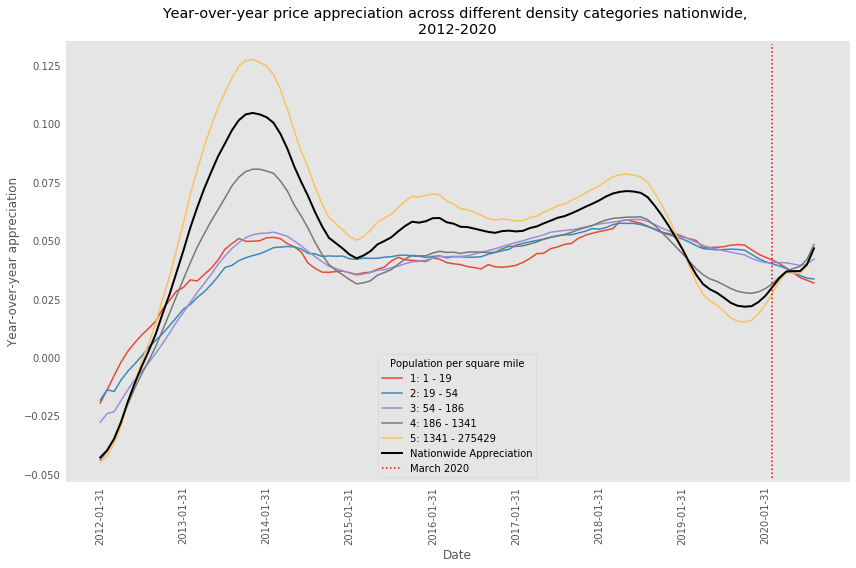

In [57]:
plot_appreciation_trend_national('Pop_density',5,'density','2012','01',legend_title='Population per square mile')

Next: Visualize share of zipcodes experiencing year-over-year price declines, by metro area and nationwide (and perhaps within particular categories?).

In [58]:
#Now let's write a formula to calculate the average for a range of date columns in a df weighted by zipcode population
def calc_weighted_avg(df,date_cols):
    
    #The below is the roundabout way for calculating the weighted average (by Zipcode population)
    price_array_list = []
        
    for i in date_cols:
        mean_df = df[['RegionName',i,'Pop_2018']]
        mean_df = mean_df.dropna(subset=[i,'Pop_2018'])
            
        price_array = mean_df[i]
        weight_array = mean_df['Pop_2018']
            
        weight_avg_price = np.average(price_array,weights=weight_array)
        price_array_list.append(weight_avg_price)
        
    return price_array_list

In [59]:
def calc_zip_decline_share(df,start_year,start_month):
    #get the relevant date columns
    date_cols = get_date_cols(df,start_year,start_month)
    
    new_df = df.replace([np.inf, -np.inf], np.nan)
    new_df = new_df.dropna(subset=[category])
    
    neg_apprec_shares = []
    for i in range(len(date_cols)-12): #Note that this has to be 12 and not 1: since date cols represent months
        prev_year = date_cols[i]
        curr_year = date_cols[i+12]
        
        prev_year_df = new_df[['RegionName',prev_year]]
        curr_year_df = new_df[['RegionName',curr_year]]
        
        apprec_array = (new_df[curr_year] - new_df[prev_year])/new_df[prev_year]
        neg_apprec_share = sum([i<=0 for i in apprec_array])/len(apprec_array)
        neg_apprec_shares.append(neg_apprec_share)

    #return neg_apprec_shares,new_date_cols
    return neg_apprec_shares,date_cols

In [60]:
zip_decline_array = calc_zip_decline_share(master_df,'2012','01')

In [61]:
metro_set = ['New York-Newark-Jersey City',
 'Los Angeles-Long Beach-Anaheim',
 'Washington-Arlington-Alexandria',
 'Boston-Cambridge-Newton']

In [62]:
def plot_zip_decline_share(metros,start_year,start_month):

    nat_zip_decline_array,new_date_cols = calc_zip_decline_share(master_df,start_year,start_month)
    
    metro_zip_decline_arrays = []
    for i in range(len(metros)):
        metro_df = master_df[master_df['Metro']==metros[i]]
        metro_zip_decline_array,metro_date_cols = calc_zip_decline_share(metro_df,start_year,start_month)
        metro_zip_decline_arrays.append(metro_zip_decline_array)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    for i in range(len(metros)):
        ax.plot(new_date_cols[12:],metro_zip_decline_arrays[i],label=str(metros[i]))
        
    ax.plot(new_date_cols[12:],nat_zip_decline_array,linewidth=2,color='k',label='National Share')
    
    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,color='r',ls=':',label='March 2020')
 
    ax.set_ylabel('Share of zipcodes')
    ax.set_xlabel('Date')
    ax.set_title('Share of zipcodes experiencing year-over-year price declines, ' + str(start_year) + '-2020')
    
    #Hide the gridlines
    ax.grid(False)
    
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 12th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::12]))
    for label in temp:
        label.set_visible(False)

    ax.legend()
    
    plt.show()

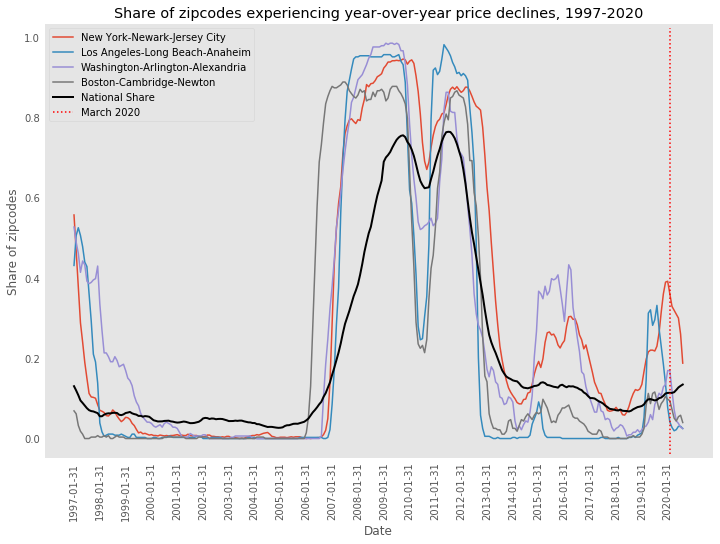

In [63]:
plot_zip_decline_share(metro_set,'1997','01')

In [64]:
metro_set = ['New York-Newark-Jersey City',
 'San Francisco-Oakland-Hayward',
 'San Jose-Sunnyvale-Santa Clara']

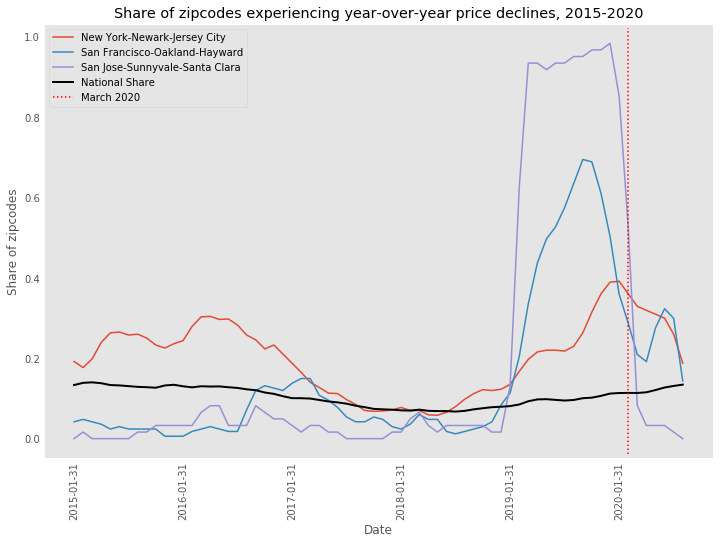

In [65]:
plot_zip_decline_share(metro_set,'2015','01')

Now do the above by category.

The San Jose line looks suspicious....let's dig into this a bit.

In [66]:
#Just use this line to set the date columns when plotting the category trend - easier than
#going back and fixing the formula
date_cols = get_date_cols(master_df,'2016','01')

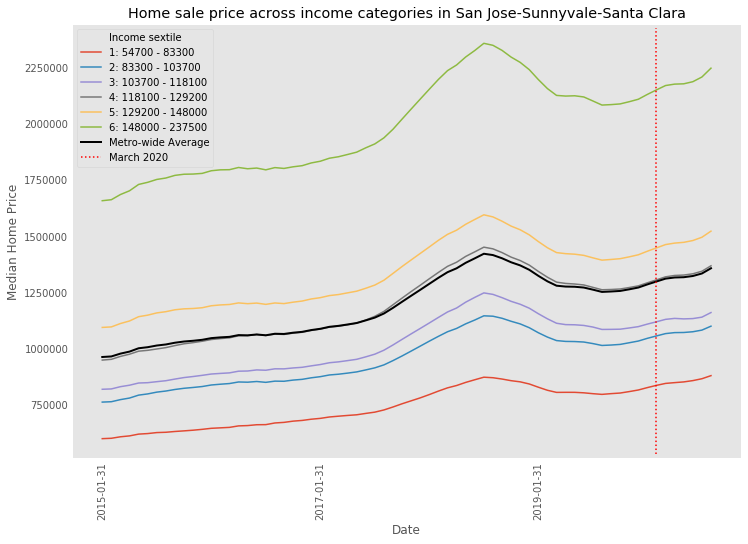

In [67]:
plot_category_trend('San Jose-Sunnyvale-Santa Clara','Med_income',6,'income',legend_title='Income sextile')



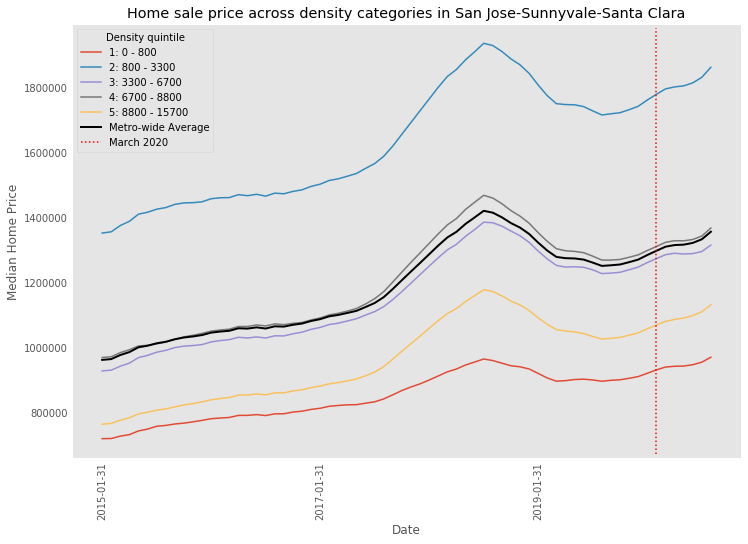

In [68]:
plot_category_trend('San Jose-Sunnyvale-Santa Clara','Pop_density',5,'density',legend_title='Density quintile')


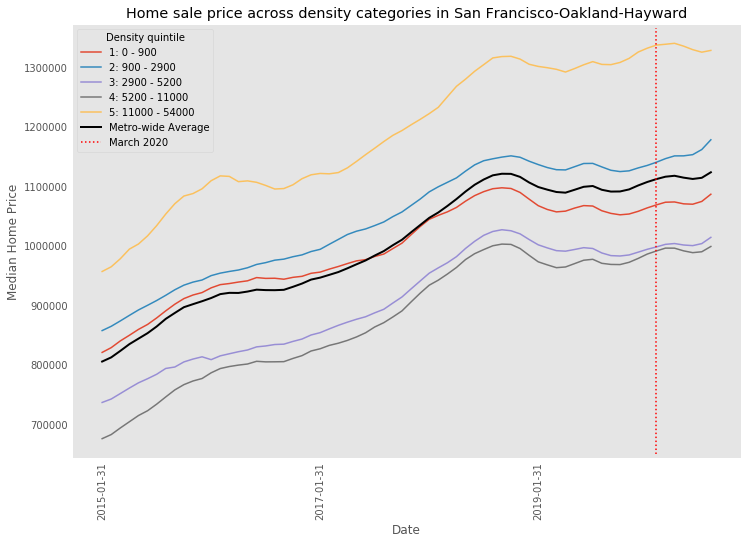

In [69]:
plot_category_trend('San Francisco-Oakland-Hayward','Pop_density',5,'density',legend_title='Density quintile')


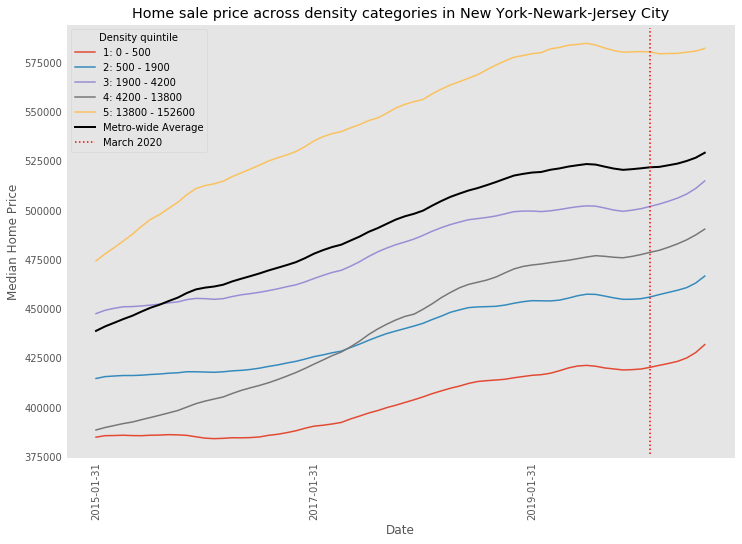

In [70]:
plot_category_trend('New York-Newark-Jersey City','Pop_density',5,'density',legend_title='Density quintile')


The San Jose trend might be right after all.....what it appears is that there was simply an abrupt spike in sale prices (across all zipcodes regardless of income and density category) in 2018 followed by a sudden drop. The important question is: why did this happen? And see: does the story change if you look at demographic categories?

Next: within individual metro areas, better understand what zips are experiencing year-over-year price declines. 

In [71]:
def plot_depreciation_by_category(metro,category,num_bins,cat_title,start_year,start_month,legend_title=None,decs=2):
    
    #get the relevant date columns
    date_cols = get_date_cols(master_df,start_year,start_month)
    
    metro_df = master_df[master_df['Metro']==metro]
    metro_df = metro_df.replace([np.inf, -np.inf], np.nan)
    metro_df = metro_df.dropna(subset=[category])
    
    #Create a new column with appropriately-labeled categories
    new_labels,cat_labels = get_category_bins(metro_df,category,num_bins,decs)
    metro_df['Bins'] = new_labels
    
    #Now get the depreciation array for each category
        
    zip_decline_arrays = []
    for label in cat_labels:
        cat_df = metro_df[metro_df['Bins']==label]
        
        cat_zip_decline_array,cat_date_cols = calc_zip_decline_share(cat_df,start_year,start_month)
        zip_decline_arrays.append(cat_zip_decline_array)
    
    
    #############################    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for i in range(len(cat_labels)):
        ax.plot(date_cols[12:],zip_decline_arrays[i],label=str(cat_labels[i])) #Same: this has to be plus 12
    
    #HERE: Add in metro-wide share
    metro_zip_decline_array,metro_date_cols = calc_zip_decline_share(metro_df,start_year,start_month)
    ax.plot(metro_date_cols[12:],metro_zip_decline_array,linewidth=2,color='k',label='Metro-wide Share')
    
    
    #HERE: Add in Nation-wide share
    nat_zip_decline_array,new_date_cols = calc_zip_decline_share(master_df,start_year,start_month)
    ax.plot(new_date_cols[12:],nat_zip_decline_array,linewidth=1,color='k',ls='--',label='National Share')

    ax.axvline(x='2020-02-29', ymin=0.01, ymax=0.99,linewidth=2,color='r',ls=':',label='March 2020')
 
    ax.set_ylabel('Share of zipcodes')
    ax.set_xlabel('Date')
    ax.set_title('Share of zipcodes experiencing year-over-year price declines, ' + str(start_year) + '-2020' + '\n in ' + str(metro) + ' by ' + cat_title + ' categories')
    
    #Hide the gridlines
    ax.grid(False)
    
    ax.ticklabel_format(style='plain', axis='y',useOffset=False)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    
    ax.tick_params(axis ='both', which ='both', length = 0)
 
    #Only show every 12th label
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::12]))
    for label in temp:
        label.set_visible(False)

    ax.legend(title=legend_title)
    
    plt.show()
    

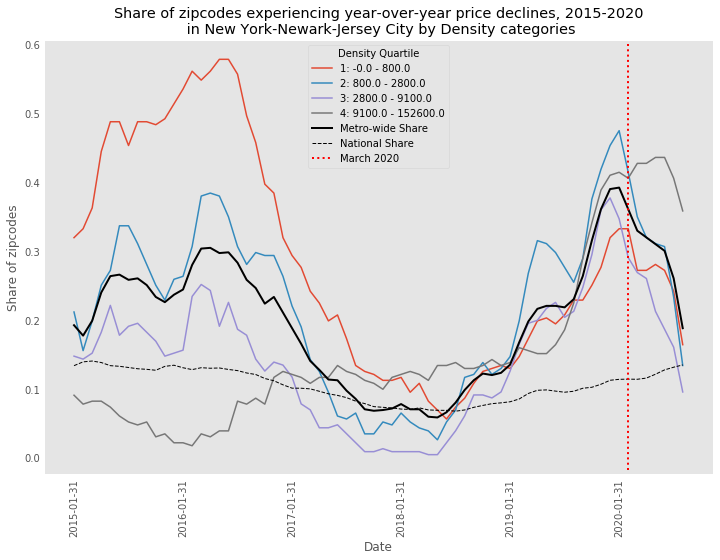

In [72]:
plot_depreciation_by_category('New York-Newark-Jersey City','Pop_density',4,'Density','2015','01',legend_title='Density Quartile',decs=-2)


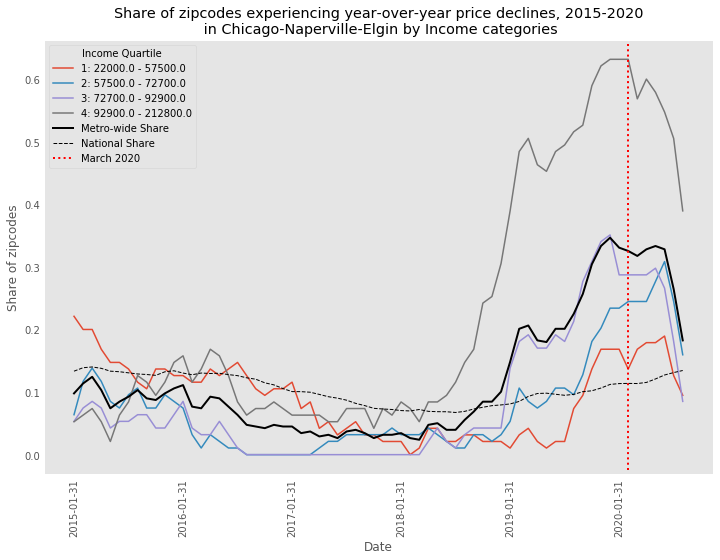

In [73]:
plot_depreciation_by_category('Chicago-Naperville-Elgin','Med_income',4,'Income','2015','01',legend_title='Income Quartile',decs=-2)


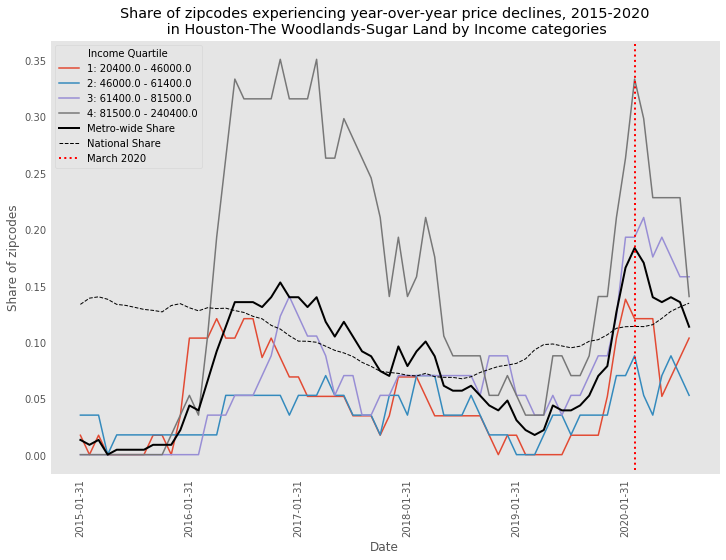

In [74]:
plot_depreciation_by_category('Houston-The Woodlands-Sugar Land','Med_income',4,'Income','2015','01',legend_title='Income Quartile',decs=-2)



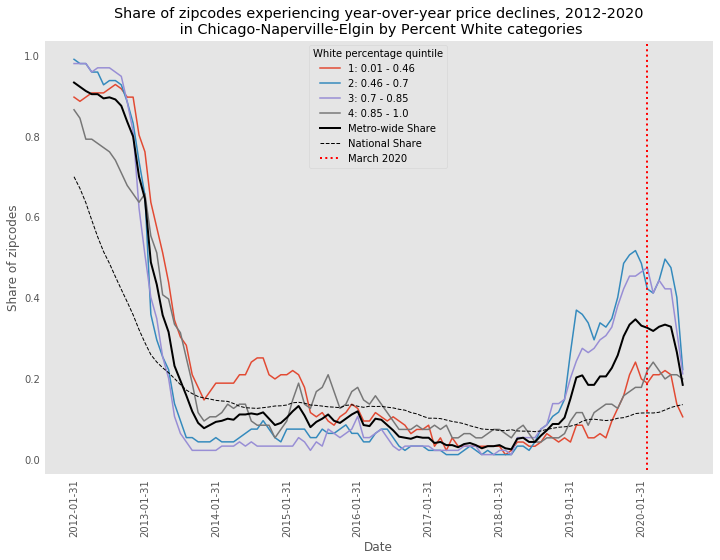

In [75]:
plot_depreciation_by_category('Chicago-Naperville-Elgin','White_portion',4,'Percent White','2012','01',legend_title='White percentage quintile',decs=2)


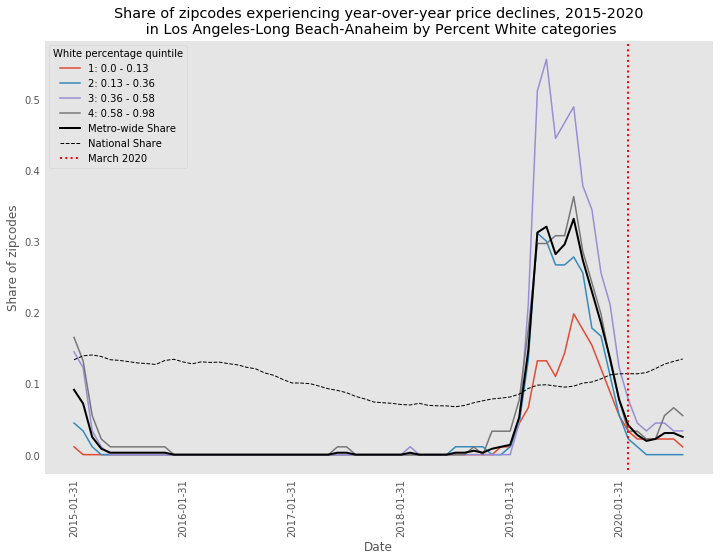

In [76]:
plot_depreciation_by_category('Los Angeles-Long Beach-Anaheim','White_portion',4,'Percent White','2015','01',legend_title='White percentage quintile',decs=2)

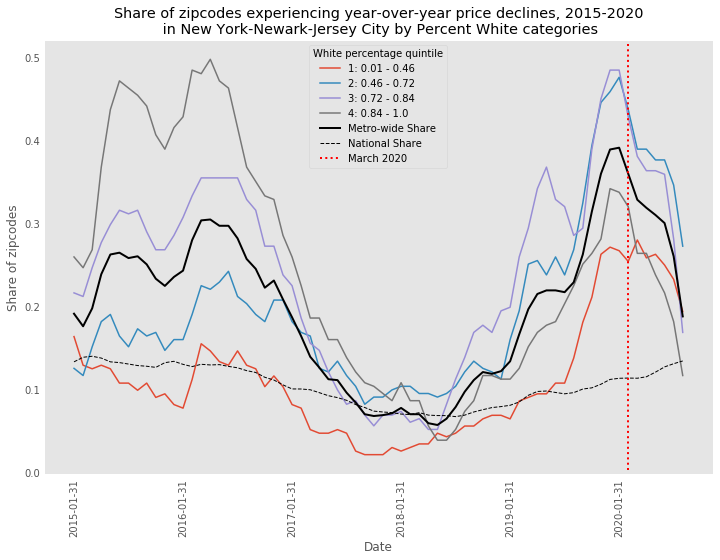

In [77]:
plot_depreciation_by_category('New York-Newark-Jersey City','White_portion',4,'Percent White','2015','01',legend_title='White percentage quintile',decs=2)

